In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.style as style
import seaborn as sns
import time
import random
from jupyterthemes import jtplot
import gudhi as gd
import math
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
from gudhi.persistence_graphical_tools import plot_persistence_diagram
from datetime import date
from scipy.integrate import simps

# Jupyter NB customizations
# warnings.filterwarnings('ignore')
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
today = date.today()
colors = sns.color_palette("colorblind").as_hex()
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
plt.rc('axes', titlesize=20)                                                   # fontsize of the axes title
plt.rc('axes', labelsize=20)                                                   # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)                                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=20)                                                  # fontsize of the tick labels
plt.rc('legend', fontsize=18)                                                  # legend fontsize
plt.rc('figure', titlesize=20)                                                 # fontsize of the figure title
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = [13, 9]

# Extracting and Visualizing dataset

Load halo sample from "halos_0.0.ascii" file with pandas:

In [13]:
loc = r"/Users/raulbv/Google Drive/My Drive/Documents/Cosmic_Web/halos_0.0.ascii"    # path to halo file

# Reading the data
start1 = time.time()

df = pd.read_csv(loc, delimiter=" ", usecols=["x", "y", "z", "m200b", "PosUncertainty"])[18:]
x, y, z, pos_sigma, m200b = df.values.astype(np.float).T 
log_m = np.log10(m200b)

end1 = time.time()
print(f"Exracting the data took {end1-start1:.2f} seconds.")

# Doing a 3-D scatter plot of the positiions as well as plotting the histogram of mass distribution
n_halos = len(x)

Exracting the data took 0.71 seconds.


<ipython-input-13-858dd714b837>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x, y, z, pos_sigma, m200b = df.values.astype(np.float).T


Plot halo mass distribution and spatial distribution,

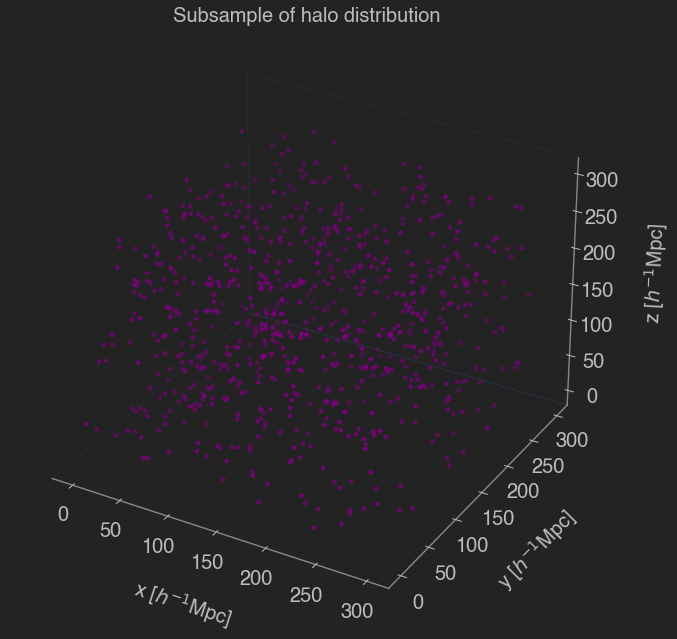

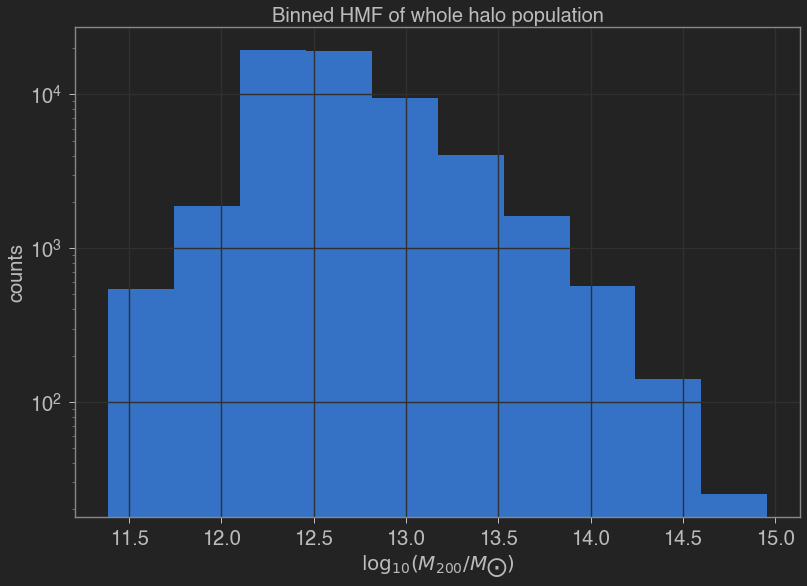

Plotting the particles' position and the binned HMF took 3.68 seconds.


In [14]:
# Subsampling the data 
n_subsamp = 800

samples = np.arange(n_halos)
idx_subsamp = np.random.choice(samples, n_subsamp)
idx_subsamp = np.sort(idx_subsamp)

x_s, y_s, z_s, log_m_s, pos_sigma_s = x[idx_subsamp], y[idx_subsamp], z[idx_subsamp], log_m[idx_subsamp], pos_sigma[idx_subsamp] 

start2 = time.time()

fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_s, y_s, z_s, color="purple")
ax.set_xlabel("x [$h^{-1}$Mpc]", labelpad=30)
ax.set_ylabel("y [$h^{-1}$Mpc]", labelpad=30)
ax.set_zlabel("z [$h^{-1}$Mpc]", labelpad=30)
ax.set_title("Subsample of halo distribution")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('b')
ax.yaxis.pane.set_edgecolor('b')
ax.zaxis.pane.set_edgecolor('b')
# ax.set_axis_off()
ax.grid(False)
plt.tight_layout()
if True:
    plt.savefig('Halo__Subsample__Distribution.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.figure(figsize=(13,9))
plt.hist(log_m)
plt.xlabel(r"$\log_{10}(M_{200}/M_{\bigodot})$")
plt.yscale("log")
plt.ylabel("counts")
plt.title("Binned HMF of whole halo population")
if False:
    plt.savefig('Halo__Binned_HMF.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
plt.show()

end2 = time.time()
print(f"Plotting the particles' position and the binned HMF took {end2-start2:.2f} seconds.")

# Applying MST to halo subsample

Producing the KNN graph and building the MST took 0.01 seconds.
Extracting the edge information took 0.00 seconds.
800
Number of edges is small enough that does not require subsampling for plotting.
Plotting the MST took 1.55 seconds.


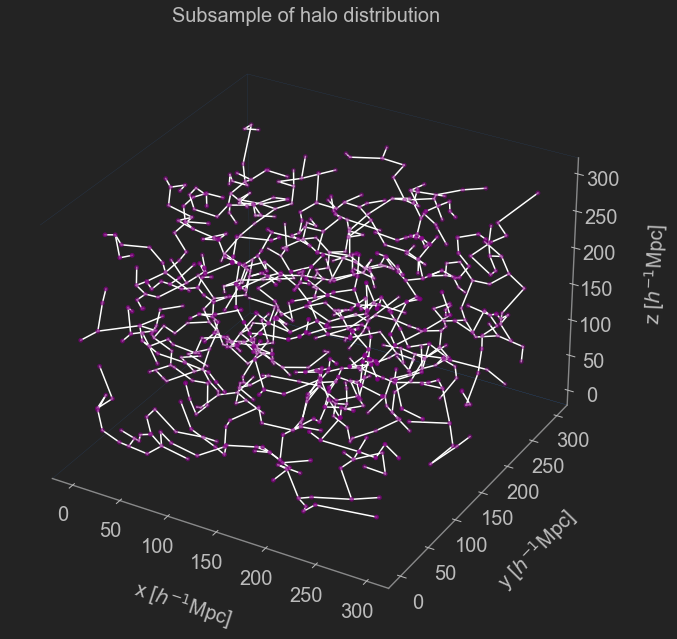

'\n    TO DO:\n    -----\n        (1) Build class for MST with above functions as methods, where each instance will be a point distribution.\n        (2) Study what part of the Alpha Complex the MST is tracing.\n        (3) Understand the difference between the DTM filtration and the Alpha Complex:\n                => Plot difference between AC and DTM persistence diagrams!\n                Q: Does the DTM filtration preserve the physical interpretation of the Alpha Complex?\n'

In [4]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree

def Build_MST(x,y,z,
             k=20):
    """
    Builds the Minimum Spanning Tree from a 3D point distribution.
    First, it constructs the K-Nearest-Neighbor graph, then it builds
    the MST from the graph outputting the Weighted Adjacency Matrix of
    the graph associated to the point distribution.
    
    Parameters:
    ----------
    x: array-like
       x-coordinates of point distribution.
    y: array-like
       y-coordinates of point distribution.
    z: array-like
       z-coordinates of point distribution.
    k: int
       Number of neighbors to consider when building graph.
       Default is k=20 as this gives best accuracy (complete
       graph) to computatonial time ratio (see Nadoo et al. 2020).
       
    Returns:
    -------
    mst: <class 'scipy.sparse.csr.csr_matrix'>
         The N x N compressed-sparse representation of the 
         undirected minimum spanning tree over the input.
    """
    start3 = time.time()
    
    # Bring coordinates into right format
    coords = np.array([x,y,z]).T
    # Build MST
    k_nearest_neighbour_graph = kneighbors_graph(coords, 20, mode="distance")
    mst = minimum_spanning_tree(k_nearest_neighbour_graph, overwrite=True)
    
    end3 = time.time()
    print(f"Producing the KNN graph and building the MST took {end3-start3:.2f} seconds.")
    return mst

def extract_edges(x, y , z, 
                 plot=True, savefig=False, make_movie=False):
    """
    This function extracts the edges from a MST: the (x,y,z) coordinates of
    both ends of each edge, the lengths of edges and the index wrt to the nodes.
    
    Parameters:
    ----------
    mst: <class 'scipy.sparse.csr.csr_matrix'>
         The N x N compressed-sparse representation of the 
         undirected minimum spanning tree over the input.
    plot: (Optional) Boolean
          If True, plots the point distribution with its MST.
          Default is False to save computation time.
    savefig: (Optional) Boolean
             Save the plot of the MST. Se to False by default.
    make_movie: (Optional) Bool
                Plots the MST links in a loop to make ffmpeg movie.
             
    Returns:
    -------
    Document later
    
    """
    
    # Call Build_MST method to get MST adjacency matrix
    mst = Build_MST(x, y , z)
    mst = mst.tocoo()
    start4 = time.time()
    # Find the indexes of the ends of each edges wrt to nodes
    idx_end_a, idx_end_b = mst.row, mst.col
    # Find the respectieve coordinates
    x_a, x_b = x[idx_end_a], x[idx_end_b]
    y_a, y_b = y[idx_end_a], y[idx_end_b] 
    z_a, z_b = z[idx_end_a], z[idx_end_b] 
    # Storing edge information for return
    edge_x = np.array([x_a, x_b])
    edge_y = np.array([y_a, y_b])
    edge_z = np.array([z_a, z_b])
    edge_lengths = mst.data
    edge_idxs = np.array([idx_end_a, idx_end_b])
    
    end4 = time.time()
    print(f"Extracting the edge information took {end4-start4:.2f} seconds.")
    
    print(len(x_s))
    # (Optional) Plot MST including point distribution
    if plot is True:
        start5 = time.time()
        n_edges = edge_idxs.shape[-1]
        
        fig = plt.figure(figsize=(13,9))
        ax = fig.add_subplot(111, projection='3d')
        # Setting aesthetic customs
        ax.set_xlabel("x [$h^{-1}$Mpc]", labelpad=30)
        ax.set_ylabel("y [$h^{-1}$Mpc]", labelpad=30)
        ax.set_zlabel("z [$h^{-1}$Mpc]", labelpad=30)
        ax.set_title("Subsample of halo distribution")
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        # Now set color to black (or whatever is "invisible")
        ax.xaxis.pane.set_edgecolor('b')
        ax.yaxis.pane.set_edgecolor('b')
        ax.zaxis.pane.set_edgecolor('b')
        # ax.set_axis_off()
        ax.grid(False)
        plt.tight_layout()

        
        # Making sure we only plot less than a certain edge threshold to avoid
        # kernel death.
        thd = 1500
        if n_edges <= thd:
            print("Number of edges is small enough that does not require subsampling for plotting.")
            ax.scatter(x, y, z, color="purple")
            for i in range(n_edges):
                e_x = np.array([x_a[i], x_b[i]])
                e_y = np.array([y_a[i], y_b[i]])
                e_z = np.array([z_a[i], z_b[i]])
                if make_movie is True:
                    plt.savefig(r"C:\Users\raul_\OneDrive\Escritorio\Side__Projects\Cosmology_Learning\Cosmic_Web\MSTS_Movie\img_{}.png".format(i), 
                                format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
                    ax.view_init(30, i/4)
                ax.plot(e_x, e_y, e_z, color="white")
            
        else:
            print(f"Number of edges exceeds {thd}. Subsampling is required to avoid kernel death.")
            for i in range(600):
                e_x = np.array([x[idx_end_a[i]], x[idx_end_b[i]]])
                e_y = np.array([y[idx_end_a[i]], y[idx_end_b[i]]])
                e_z = np.array([z[idx_end_a[i]], z[idx_end_b[i]]])
                ax.plot(e_x, e_y, e_z, color="mediumorchid")
            ax.scatter(x[:600], y[:600], z[:600], color="purple")

        if savefig is True:
                plt.savefig('Halo__Subsample__MST.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
        end5 = time.time()
        
        print(f"Plotting the MST took {end5-start5:.2f} seconds.")
        plt.show()
        
    return edge_lengths, edge_x, edge_y, edge_z, edge_idxs


# Now producing a MST from this subsample
# def MST()

coords = np.array([x_s, y_s, z_s]).T
edge_lengths, edge_x, edge_y, edge_z, edge_index = extract_edges(x_s, y_s, z_s, plot=True, savefig=False)


"""
    TO DO:
    -----
        (1) Build class for MST with above functions as methods, where each instance will be a point distribution.
        (2) Study what part of the Alpha Complex the MST is tracing.
        (3) Understand the difference between the DTM filtration and the Alpha Complex:
                => Plot difference between AC and DTM persistence diagrams!
                Q: Does the DTM filtration preserve the physical interpretation of the Alpha Complex?
"""

Now that we have extracted the edges of the MST, we can plot the distribution of edge length 

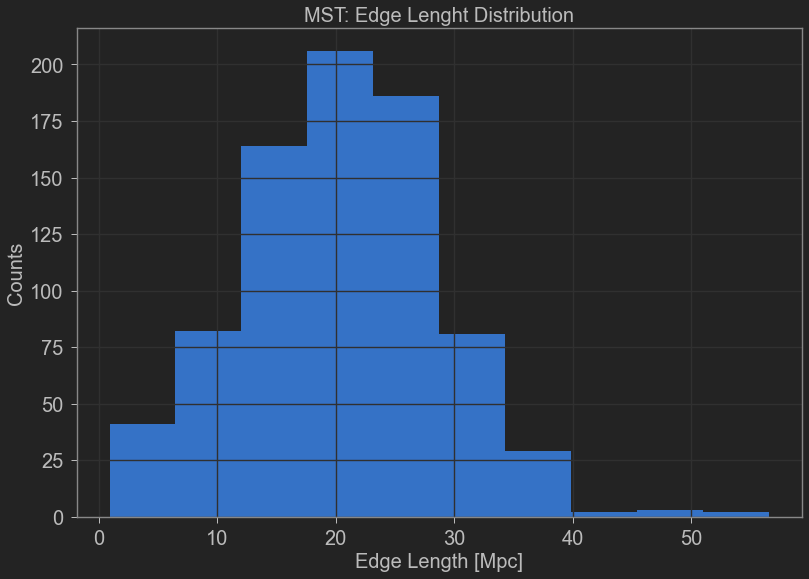

In [5]:
plt.figure()
plt.hist(edge_lengths)
plt.xlabel("Edge Length [Mpc]"); plt.ylabel("Counts")
plt.title("MST: Edge Lenght Distribution")
plt.show()

## Applying TDA on halos

### DTM filtration

Construct the DTM filtration with a unweighted Rips complex, (k=1, see https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-DTM-filtrations.ipynb) and find its associated simplex tree. Note that creating the Rips complex is extremely computationally heavy. Subsequently, we can compute its persistence



In [6]:
from gudhi.dtm_rips_complex import DTMRipsComplex

start6 = time.time()
dtm_rips = DTMRipsComplex(points=coords, k=1)
end6 = time.time()
print(f"Building the DTM filtration with a Rips complex took {end6-start6:.2f} seconds.")

start7 = time.time()
st = dtm_rips.create_simplex_tree(max_dimension=2)
end7 = time.time()
print(f"Building the simplex tree (data structure) of the DTM filtration took {end7-start7:.2f} seconds.")

start8 = time.time()
# p = st.persistence()
end8 = time.time()
print(f"Computing the persistence of the DTM filtration took {end8-start8:.2f} seconds.")

# Plotting persistence diagram


Building the DTM filtration with a Rips complex took 0.01 seconds.
Building the simplex tree (data structure) of the DTM filtration took 8.20 seconds.
Computing the persistence of the DTM filtration took 0.00 seconds.


In [7]:
start8 = time.time()
p = st.persistence()
end8 = time.time()
print(f"Computing the persistence of the DTM filtration took {end8-start8:.2f} seconds.")

Computing the persistence of the DTM filtration took 208.22 seconds.


Define a few functions created by Gudhi to create DTM filtrations in Rips and Alpha complexes (see https://github.com/VincentRouvreau/TDA-tutorial/blob/master/Tuto-GUDHI-DTM-filtrations.ipynb):

In [26]:
def DTM(X,query_pts,m):
    '''
    Compute the values of the DTM (with exponent p=2) of the empirical measure of a point cloud X
    Require sklearn.neighbors.KDTree to search nearest neighbors
    
    Input:
    X: a nxd numpy array representing n points in R^d
    query_pts:  a kxd numpy array of query points
    m: parameter of the DTM in [0,1)
    
    Output: 
    DTM_result: a kx1 numpy array contaning the DTM of the 
    query points
    '''
    N_tot = X.shape[0]     
    k = math.floor(m*N_tot)+1   # number of neighbors
    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    NN_Dist, NN = kdt.query(query_pts, k, return_distance=True)  

    DTM_result = np.sqrt(np.sum(NN_Dist*NN_Dist,axis=1) / k)
    
    return DTM_result


def Filtration_value(p, fx, fy, d, n = 10):
    '''
    Compute the filtrations values of the edge [x,y] in the weighted Rips filtration
    If p is not 1, 2 or 'np.inf, an implicit equation is solved
    The equation to solve is G(I) = d, where G(I) = (I**p-fx**p)**(1/p)+(I**p-fy**p)**(1/p)
    We use a dichotomic method
    
    Input:
    p: parameter of the weighted Rips filtration, in [1, +inf) or np.inf
    fx: filtration value of the point x
    fy: filtration value of the point y
    d: distance between the points x and y
    n: number of iterations of the dichotomic method
        
    Output: 
    val : filtration value of the edge [x,y], i.e. solution of G(I) = d    
    '''
    if p==np.inf:
        value = max([fx,fy,d/2])
    else:
        fmax = max([fx,fy])
        if d < (abs(fx**p-fy**p))**(1/p):
            value = fmax
        elif p==1:
            value = (fx+fy+d)/2
        elif p==2:
            value = np.sqrt( ( (fx+fy)**2 +d**2 )*( (fx-fy)**2 +d**2 ) )/(2*d)            
        else:
            Imin = fmax; Imax = (d**p+fmax**p)**(1/p)
            for i in range(n):
                I = (Imin+Imax)/2
                g = (I**p-fx**p)**(1/p)+(I**p-fy**p)**(1/p)
                if g<d:
                    Imin=I
                else:
                    Imax=I
            value = I
    return value


def WeightedRipsFiltration(X, F, p, dimension_max =2, filtration_max = np.inf):
    '''
    Compute the weighted Rips filtration of a point cloud, weighted with the 
    values F, and with parameter p
    
    Input:
    X: a nxd numpy array representing n points in R^d
    F: an array of length n,  representing the values of a function on X
    p: a parameter in [0, +inf) or np.inf
    filtration_max: maximal filtration value of simplices when building the complex
    dimension_max: maximal dimension to expand the complex
    
    Output:
    st: a guddi.SimplexTree 
    '''
    N_tot = X.shape[0]     
    distances = euclidean_distances(X)          # compute the pairwise distances
    st = gd.SimplexTree()                    # create an empty simplex tree

    for i in range(N_tot):                      # add vertices to the simplex tree
        value = F[i]
        if value<filtration_max:
            st.insert([i], filtration = F[i])            
    for i in range(N_tot):                      # add edges to the simplex tree
        for j in range(i):
            value = Filtration_value(p, F[i], F[j], distances[i][j])
            if value<filtration_max:
                st.insert([i,j], filtration  = value)
    
    st.expansion(dimension_max)                 # expand the simplex tree
    
    result_str = 'Weighted Rips Complex is of dimension ' + repr(st.dimension()) + ' - ' + \
        repr(st.num_simplices()) + ' simplices - ' + \
        repr(st.num_vertices()) + ' vertices.' +\
        ' Filtration maximal value is ' + str(filtration_max) + '.'
    print(result_str)

    return st

def DTM_WeightedRips_Filtration(X, m, p, dimension_max =3, filtration_max = np.inf,
                                    print_time=True):
    '''
    Constructs the simplex tree of a  DTM-filtration of a point cloud, with parameters m and p.
    
    Parameters:
    ----------
    X: array-like
       a nxd numpy array representing n points in R^d
    m: float
       parameter of the DTM, in [0,1) 
    p: float or np.inf
       parameter of the filtration, in [0, +inf) or np.inf
    filtration_max: float
                    Maximal filtration value of simplices when building the complex
    dimension_max: int
                    Maximal dimension to expand the complex
    
    Returns:
    -------
    st: gudhi.SimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.   
    '''
    
    start1 = time.time()
    DTM_values = DTM(X,X,m)
    end1 = time.time()
    
    
    start2 = time.time()
    st = WeightedRipsFiltration(X, DTM_values, p, dimension_max, filtration_max)
    end2 = time.time()
    
    start3 = time.time()
    persistence = st.persistence()    
    end3 = time.time()
    
    # (Optional) Print the performance of each of the computations
    if print_time is True:
        print(f"Building the DTM filtration with a Rips complex took {end1-start1:.2f} seconds.")
        print(f"Building the simplex tree (data structure) of the DTM filtration took {end2-start2:.2f} seconds.")
        print(f"Computing the persistence of the DTM filtration took {end3-start3:.2f} seconds.")

    return persistence

def AlphaWeighted_Rips_Filtration(X, F, p,dimension_max=3, filtration_max=np.inf,
                                      print_time=True):
    '''
    /!\ this is a heuristic method, to speed-up the computation
    It computes the weighted Rips filtration as a subset of the alpha complex
    
    Parameters:
    ----------
    X: array-like
       a nxd numpy array representing n points in R^d
    m: float
       parameter of the DTM, in [0,1) 
    F: array-like
       Values of a function on discrete space X.
    p: float or np.inf
       parameter of the filtration, in [0, +inf) or np.inf
    filtration_max: float
                    Maximal filtration value of simplices when building the complex
    dimension_max: int
                    Maximal dimension to expand the complex
    
    Returns:
    -------
    st: gudhiSimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.   
    '''
    N_tot = X.shape[0]     
    distances = euclidean_distances(X)          #compute the pairwise distances
    
    start1 = time.time()
    st_alpha = gd.AlphaComplex(points=X).create_simplex_tree()    
    st = gd.SimplexTree()                   #create an empty simplex tree
    
    for simplex in st_alpha.get_skeleton(2):            #add vertices with corresponding filtration value
        if len(simplex[0])==1:
            i = simplex[0][0]
            st.insert([i], filtration  = F[i])
        if len(simplex[0])==2:                     #add edges with corresponding filtration value
            i = simplex[0][0]
            j = simplex[0][1]
            value = Filtration_value(p, F[i], F[j], distances[i][j])
            st.insert([i,j], filtration  = value)

    st.expansion(dimension_max)                 #expand the complex
    end1 = time.time()
    result_str = 'Alpha Weighted Rips Complex is of dimension ' + repr(st.dimension()) + ' - ' + \
        repr(st.num_simplices()) + ' simplices - ' + \
        repr(st.num_vertices()) + ' vertices.' +\
        ' Filtration maximal value is ' + str(filtration_max) + '.'
    print(result_str)
    
    if print_time is True:
        print(f"Building the simplex tree of the DTM filtration from a Heuristic Weighted Rips Complex took {end1-start1:.2f} seconds.")        
    return st

def AlphaDTM_Filtration(X, m, p, dimension_max =3, filtration_max = np.inf, 
                            print_time=True):
    '''
    /!\ this is a heuristic method, to speed-up the computation
    It computes the DTM-filtration as a subset of the alpha complex
    
    Parameters:
    ----------
    X:  2-d array
        Number of points N in R^d with shape (N, d).
     m: float
       parameter of the DTM, in [0,1) 
    p: float or np.inf
       parameter of the filtration, in [0, +inf) or np.inf
    filtration_max: float
                    Maximal filtration value of simplices when building the complex
    dimension_max: int
                    Maximal dimension to expand the complex
    
    Returns:
    -------
    st: SimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.   
    '''
    start1 = time.time()
    DTM_values = DTM(X,X,m)
    st = AlphaWeighted_Rips_Filtration(X, DTM_values, p, dimension_max, filtration_max)
    end1 = time.time()

    
    if print_time is True:
        print(f"Building the simplex tree of the DTM filtration of an Alpha Complex {end1-start1:.2f} seconds.")
    
    return st

def AlphaComplex_Filtration(X,
                 print_time=True):
    """
    Constructs the simplex tree of a DTM filtration by calculating the unweighted Rips complex. 
    The filtration is stored into a simplex tree and persistence is calculated.
    
    Parameters:
    ----------
    X:  2-d array
        Number of points N in R^d with shape (N, d).
        
    Returns:
    -------
    st: SimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.    
    """
    
    # Create the Alpha complex and store it in a simplex tree. Then compute persistence
    start1 = time.time()
    st_alpha = gd.AlphaComplex(points=X).create_simplex_tree() 
    end1 = time.time()
    
    
    if print_time is True:
        print(f"Building the simplex tree of the regular Alpha Complex took {end1-start1:.2f} seconds.")
    
    return st_alpha

Alpha Weighted Rips Complex is of dimension 3 - 25085 simplices - 797 vertices. Filtration maximal value is inf.
Building the simplex tree of the DTM filtration from a Heuristic Weighted Rips Complex took 0.30 seconds.
Building the simplex tree of the DTM filtration of an Alpha Complex 0.32 seconds.
Building the simplex tree of the regular Alpha Complex took 0.18 seconds.


Note that there are two key parameters in DTM filtrations:
 - $p \in [1,\inf)$: A higher value of p highlights higher persistence features (thus reducing topological noise)
 - $m\in[0,1)$: A distance parameter in the DTM fucntion that highlghts different regions of the dataset. 
Note that choosing a higher value of $p$ will make the persistence computation more expensive. However, a value of $p=2$ will significantly reduce topological noise (see Anai et al. 2019 - https://hal.archives-ouvertes.fr/hal-01919562/file/DTM-filtrations.pdf)

Now we plot the persistence digrams for both cases (with and without DTM filtration)

Alpha Weighted Rips Complex is of dimension 3 - 25085 simplices - 797 vertices. Filtration maximal value is inf.
Building the simplex tree of the DTM filtration from a Heuristic Weighted Rips Complex took 0.29 seconds.
Building the simplex tree of the DTM filtration of an Alpha Complex 0.32 seconds.
Building the simplex tree of the regular Alpha Complex took 0.19 seconds.


<ipython-input-28-5e73daac4096>:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  alpha_b, alpha_d = np.array(alpha_b), np.array(alpha_d)


Computing the persistence and extracting the birth and death values took 0.05 seconds.
Computing the persistence and extracting the birth and death values took 0.05 seconds.


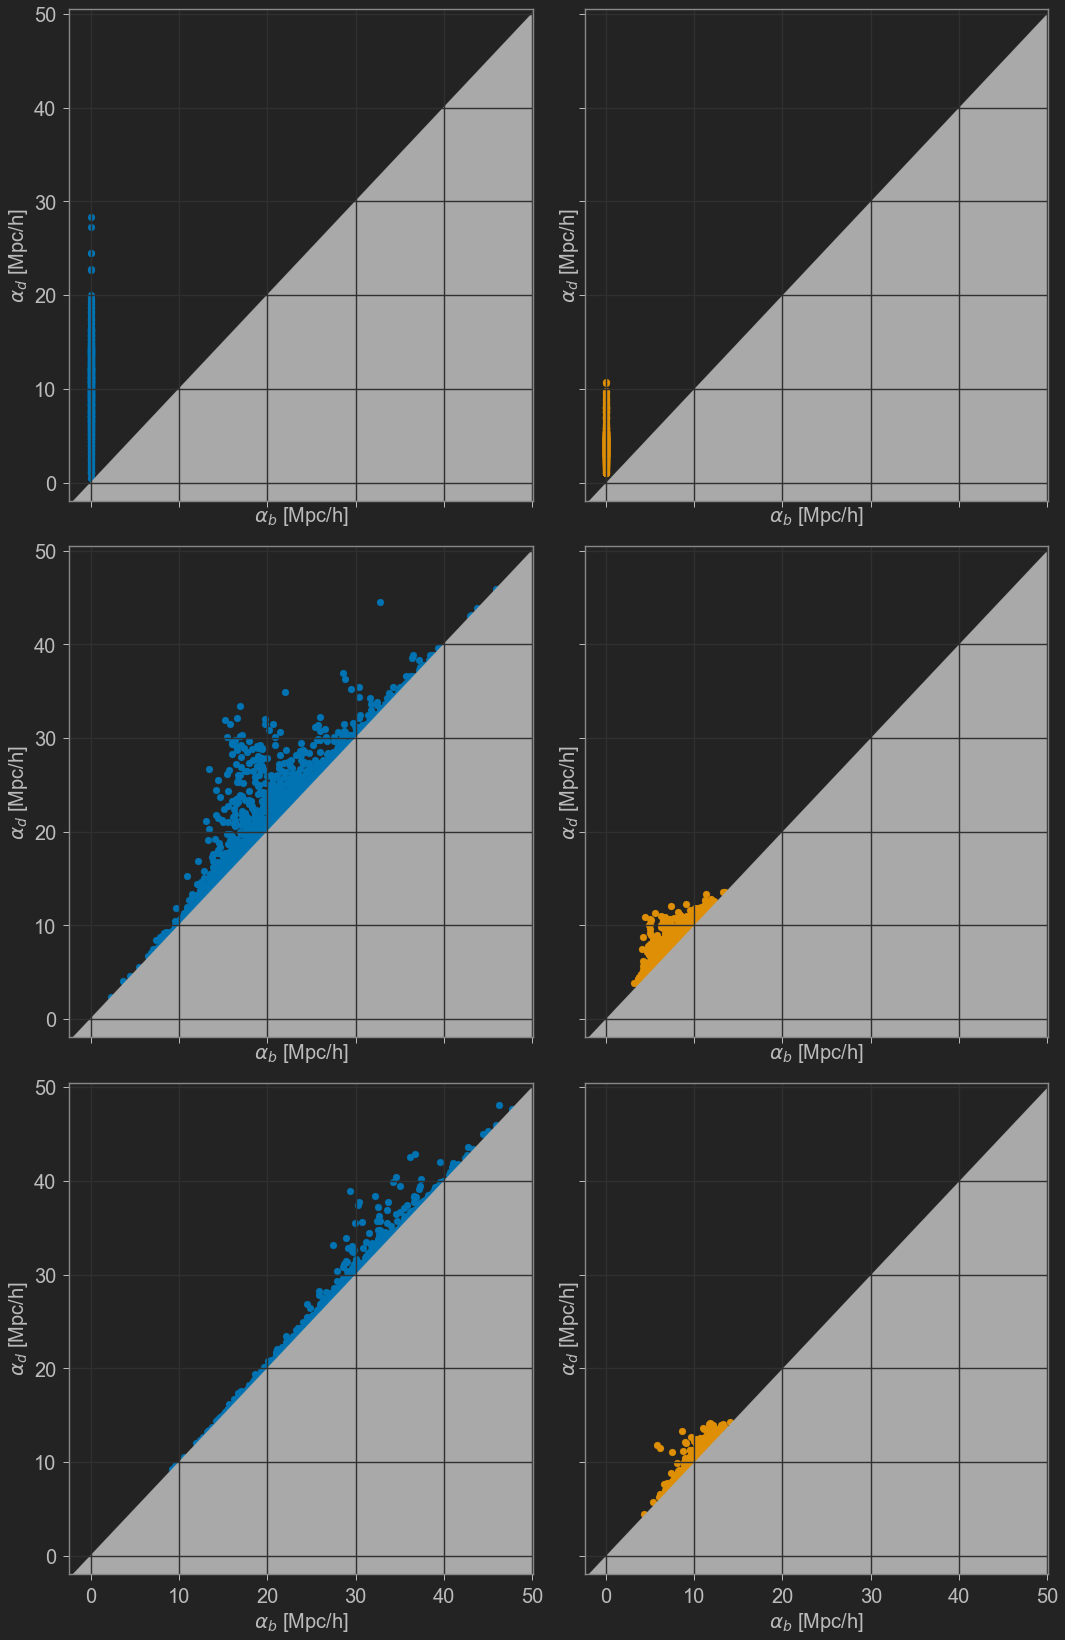

Plotting the persistence diagram took 2.17 seconds.


'\nTO DO:\n-----\n\n    (1) Finished generalized function for Betti extraction and plotting.\n        \n    (2) Plot DTM Alpha Complex vs. regular AC and understand what are the differences between as well as \n        understanding how robust the DTM Alpha Complex is to changes in p and m parameters.\n        \n    (3) Make connection between MST and Alpha complex by looking at p value and momment of eMST edge distribution.\n    \n    (?) Create a class where the constructor takes the coordinates of the simulation (and other parameters)\n        and methods construct the Complex of choice and can plot persistence and betti diagrams.\n    \n\n'

In [28]:
# Compute fitlrations for our dataset
p = np.inf                                                     # p=2 reduces most of the topological noise
m = 0
# m = np.min(edge_lengths)                                     # Let m the minimum distance of the edge distribution

st_DTM_AlphaComplex = AlphaDTM_Filtration(coords, m, p)
print("="*120)
st_AlphaComplex = AlphaComplex_Filtration(coords)


# Creating a dictionary to tell the figsize
FIG_SIZE = {
    (1,1): (13,9),
    (2,1): (9, 15),
    (3,1): (9, 18),
    (2,2): (14,14),
    (3,2): (15,23),
    (3,3): (23,23),
    (1,2): (15,7),
    (1,3): (24,9),
    (2,3): (18,13)
}

FIG_VERTICAL = {
    0: 0,
    1: 2,
    2: 4,
    3: 1,
    4: 3,
    5: 5
}

def extract_BirthDeath(st, n_subsets=1,
                       n_dim=3):
    """
    Computes the persistence of a simplex tree and then finds the alpha_b and alpha_d thresholds 
    from the persistence list that gudhi computes.
    
    Parameters:
    ----------
    st: SimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.   
    n_subsets: int
               Number of simplex trees to extract the alpha birth and death.
    n_dim: int
           Number of dimensions in the point distribution.
           
    Returns:
    -------
    alpha_b: array (2-d)
             Each row contains the alpha_b thresholds for each dimension.
    alpha_d: array (2-d)
             Each row contains the alpha_d thresholds for each dimension.
             
    Notes:
    -----
    - n_subsets should not be equal to one if st is a list of SimplexTree objects. Each object in the list would
      correspond to a different subset of the point distribution (e.g. a halo mass bin).
    """
        
    # Avoiding malfunctioning with higher order dimensional spaces (which is not of interest in this application)
    if n_dim > 3:
        raise ValueError("This function only supports up to 3 dimension in its current version.")
    else:
        pass
    
    # If simplex tree is a master list of different st objects
    start1 = time.time()
    if n_subsets > 1:
        alpha_b, alpha_d = [], []                                             # Create two master lists of birth and death alpha thresholds
        
        # Compute persistence for each simplex tree recursively
        for i in range(n_subsets):
            alpha_b_i, alpha_d_i = extract_BirthDeath(st[i], n_subsets=1)

            alpha_b.append(alpha_b_i)
            alpha_d.append(alpha_d_i)
        
        return alpha_b, alpha_d
    
    else:
        p = st.persistence()

        alpha_d, alpha_b = [], []                                                # create empty arrays and append empty sublists for number of dimensions
        for n in range(n_dim):     
            alpha_b.append([])
            alpha_d.append([])

        # Now extract alpha thresholds from persistence    
        for i in p:
            dim = i[0]
            if dim == 0: 
                alpha_b[0].append(i[1][0]**0.5)
                alpha_d[0].append(i[1][1]**0.5)
            elif dim == 1: 
                alpha_b[1].append(i[1][0]**0.5)
                alpha_d[1].append(i[1][1]**0.5)
            elif dim == 2:
                alpha_b[2].append(i[1][0]**0.5)
                alpha_d[2].append(i[1][1]**0.5)

        # Make the master lists into arrays
        alpha_b, alpha_d = np.array(alpha_b), np.array(alpha_d)
        
        end1 = time.time()
        print(f"Computing the persistence and extracting the birth and death values took {end1-start1:.2f} seconds.")

        return alpha_b, alpha_d

def plot_PersDiagram(st, nrows, ncols, n_subsets, 
                     scale="Mpc/h",
                     sharey=False, sharex=False, savefig=False):
    
    """
    Plots the persistence for any number of plots given the persistence in a stack.
    
    Parameters:
    ----------
    st: gudhi.SimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.   
    nrow: int
          nunmber of rows to plot between 1 and 3.
    ncols: int
           Number of columns between 1 and 3.
    n_subsets: int
               Number of simplex trees to extract the alpha birth and death.
    scale: str
           Units used for the alpha value for axis labelling.
    yshare: (Optional) bool
            Merge y-axis if scale is comparable.
    xshare: (Optional) bool
            Merge x-axis if scale is comparable.
    savefig: (Optional) bool
             Save plot in current folder.
    
    Output:
    ------
    None: Just plots the figure.
    """
    
    # Define some constants for plotting
    n_plots = nrows*ncols                                     # number of plots i.e. rows in the persistence stack
    fsize = FIG_SIZE[(nrows, ncols)]                           # picks right figsize from number of plots
    
    # Extract the alpha_b and alpha_d thresholds
    alpha_b, alpha_d = extract_BirthDeath(st, n_subsets)
    
    fig,ax = plt.subplots(nrows, ncols, figsize=fsize, sharex=sharex, sharey=sharey)
    
    start1 = time.time()
    # Need two cases: for when there is only one plot or more than one
    if n_plots == 1:
        ax.plot(alpha_b, alpha_d, color=color[0])
        ax.set_xlabel(f"$\alpha_b$ [{scale}]")
        ax.set_ylabel(f"$\alpha_d$ [{scale}]")
    
    else:
        ax = ax.flatten()
        shape_b, shape_d = np.shape(alpha_b), np.shape(alpha_d)
        
        n_subsets = shape_b[0]

        # Checking if we have more than one subset of points (e.g. more than one halo bin)
        z = 0
        if len(shape_b)>1:
            for j in range(n_subsets):
                curr_alpha_b, curr_alpha_d = alpha_b[j], alpha_d[j]
                
                for k in range(int(n_plots//n_subsets)):
                    # If a vertical comparison of persistence is desired, then one needs to change 
                    # the plotting counter
                    if nrows > ncols:
                        p = FIG_VERTICAL[z]
                    else:
                        p = z
                    ax[p].scatter(curr_alpha_b[k], curr_alpha_d[k], c=colors[j])
                    z += 1
        
        else:
            for i in range(n_plots):
                ax[i].scatter(alpha_b[i], alpha_d[i], c=colors[0])
        
        # Labelling axis and including second half of triangle
        for l in range(n_plots):
            ax[l].set_xlabel(r"$\alpha_b$ [{}]".format(scale))
            ax[l].set_ylabel(r"$\alpha_d$ [{}]".format(scale))
            axis_start, axis_end = ax[l].get_ylim()
            ax[l].add_patch(mpatches.Polygon([[axis_start, axis_start], [axis_end, axis_start], [axis_end, axis_end]], fill=True, color='darkgrey'))
            
    plt.tight_layout()
    if savefig is True:
        plt.savefig(f'Halo_-_PersDiagram_-_{today}.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
    plt.show()
    
    end1 = time.time()
    print(f"Plotting the persistence diagram took {end1-start1:.2f} seconds.")
    
    return None

# Testing the plotting function
ST = [st_AlphaComplex, st_DTM_AlphaComplex]

# plot_PersDiagram(st_AlphaComplex, nrows=1, ncols=3, n_subsets=1,
#                  sharey=True, sharex=True)

# plot_PersDiagram(st_DTM_AlphaComplex, nrows=1, ncols=3, n_subsets=1,
#                  sharey=True, sharex=True)

plot_PersDiagram(ST, nrows=3, ncols=2, n_subsets=len(ST),
                 sharey=True, sharex=True, savefig=False)

"""
TO DO:
-----

    (1) Finished generalized function for Betti extraction and plotting.
        
    (2) Plot DTM Alpha Complex vs. regular AC and understand what are the differences between as well as 
        understanding how robust the DTM Alpha Complex is to changes in p and m parameters.
        
    (3) Make connection between MST and Alpha complex by looking at p value and momment of eMST edge distribution.
    
    (?) Create a class where the constructor takes the coordinates of the simulation (and other parameters)
        and methods construct the Complex of choice and can plot persistence and betti diagrams.
    

"""

Now, we plot the Betti curves:

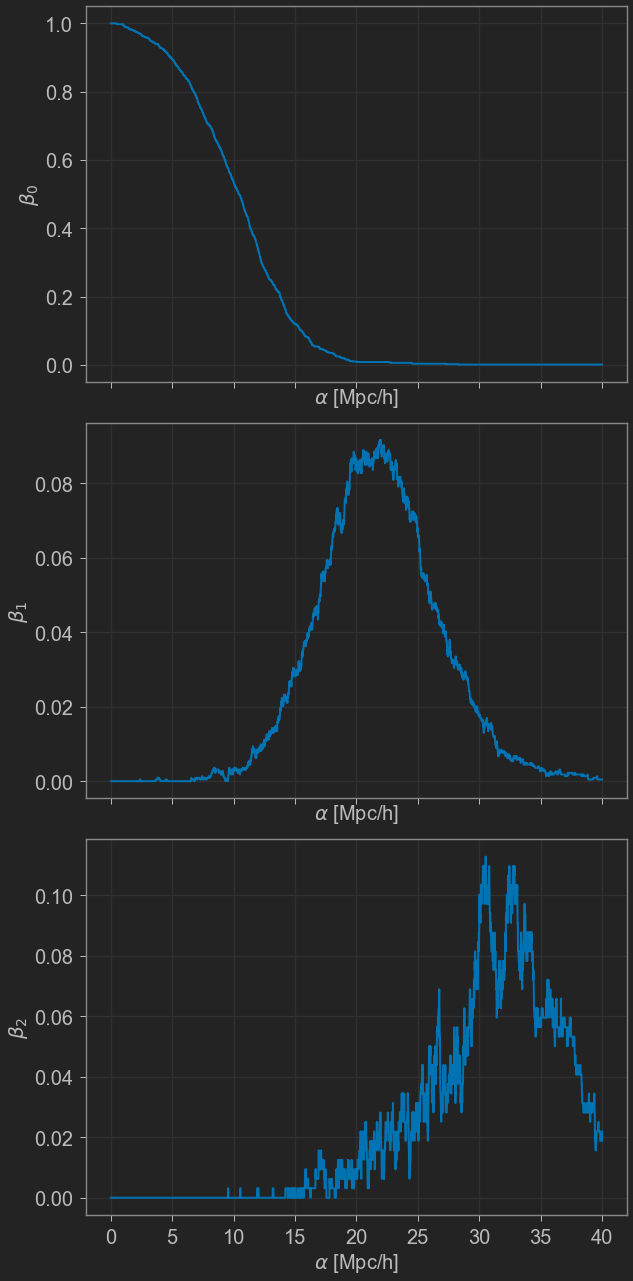

Plotting the Betti curves took 1.28 seconds.


In [52]:
def normalise_BettiCurves(alpha, betti):
    """
    This function takes an arary with betti curves up to three 
    dimensions. It standarizes betti_0 (by dividing by number
    of samples) and normalizes betti_1 and betti_2.
    
    Parameters:
    ----------
    alpha: (1-d) array-like
           Alpha array at which each of the betti numbers was sampled.
    betti: (2-d) array-like
           Betti numbers of dimensions 0, 1 and 2.
           
    Returns:
    -------
    norm_betti: (2-d) array-like
                Standarized and normalized betti numbers.
    """
    
    n_subsets = np.shape(alpha)
    # If alpha and betti are multidimensional, calculate recursively
    start1 = time.time()
    if len(np.array(alpha).shape) > 1:
        n_subsets = np.shape(alpha)[0]
        norm_betti = []                                           # Create two master lists of birth and death alpha thresholds
        
        # Compute betti numbers for each simplex tree recursively
        for i in range(n_subsets):
            norm_betti_i = normalise_BettiCurves(alpha[i], betti[i])
            norm_betti.append(norm_betti_i)
        return norm_betti

    else:
        betti_0, betti_1, betti_2 = betti.T

        # Standarizing betti_0
        n_points = betti_0[0]
        norm_betti_0 = betti_0/n_points

        # Normalizing betti_1 and betti_2 by calculating the area under their distr.
        I_1 = sp.integrate.simps(betti_1, alpha)
        I_2 = sp.integrate.simps(betti_2, alpha)

        norm_betti_1 = betti_1/I_1 
        norm_betti_2 = betti_2/I_2 

        # Putting the normalized betti into an array and returning it
        norm_betti = np.array([norm_betti_0, norm_betti_1, norm_betti_2]).T
        return norm_betti


def extract_BettiNumbers(st, n_subsets=1,
                         n_bins=5000, n_dim=3):
    """
    Computes the Betti numbers (betti_0, betti_1, betti_3) of a simplex tree.
    
    Parameters:
    ----------
    st: SimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.   
    n_subsets: int
               Number of simplex trees to extract the alpha birth and death.
    n_bins: int
            Number of alpha values from which to sample betti numbers.
    n_dim: int
           Number of dimensions in the point distribution.
           
    Returns:
    -------
    alpha: (1-d) array-like
           Alpha array at which each of the betti numbers was sampled.
    betti: (n-d) array-like
           Betti numbers of dimensions 0, 1 and 2. Array will be 2-d for 1 subset and
           3-d for multilpe subsets of X.
             
    Notes:
    -----
    - Current version of the software only supports up to 3 dimensions.
    - n_subsets should not be equal to one if st is a list of SimplexTree objects. Each object in the list would
      correspond to a different subset of the point distribution (e.g. a halo mass bin).
    """
    
    # Avoiding crashing with higher order dimensional spaces (which is not of interest in this application)
    if n_dim > 3:
        raise ValueError("Current version only supports up to 3 dimensions.")
    else:
        pass
    
    # If simplex tree is a master list of different st objects
    start1 = time.time()
    if n_subsets > 1:
        alpha, betti = [], []                                             # Create two master lists of birth and death alpha thresholds
        
        # Compute betti numbers for each simplex tree recursively
        for i in range(n_subsets):
            alpha_i, betti_i = extract_BettiNumbers(st[i], n_subsets=1)

            alpha.append(alpha_i)
            betti.append(betti_i)
        
        return alpha, betti
    
    else:
        # Create alpha array from where to sample betti numbers
        thd = 40                                                                    # no elements should be formed after this alpha threshold in Mpc/h
        alpha = np.linspace(0,thd,num=n_bins)

        # Sample betti numbers at every element in alpha array
        betti = []
        for a in alpha:
            b = st.persistent_betti_numbers(a**2,a**2)         # Gudhi uses the square of this radius as filtration values!
            betti.append(b)
        betti = np.array(betti)

        return alpha, betti
    
    


def plot_BettiCurves(st, nrows, ncols,
                      n_subsets=1, scale="Mpc/h",
                      sharey=False, sharex=False, savefig=False):
    
    """
    Plots the Betti curves for any number of points subsets of the 
    distribution X. Each subplots corresponds to one dimension.
    
    Parameters:
    ----------
    st: gudhi.SimplexTree object
        Data structure containing topological information (vertices, edges,...) for persistence
        and Betti number computation.   
    nrow: int
          nunmber of rows to plot between 1 and 3.
    ncols: int
           Number of columns between 1 and 3.
    n_subsets: int
               Number of simplex trees to extract the alpha birth and death.
    scale: str
           Units used for the alpha value for axis labelling.
    yshare: (Optional) bool
            Merge y-axis if scale is comparable.
    xshare: (Optional) bool
            Merge x-axis if scale is comparable.
    savefig: (Optional) bool
             Save plot in current folder.
    
    Output:
    ------
    None: Just plots the figure.
    """
    
    # Define some constants for plotting
    n_plots = nrows*ncols                                     # number of plots i.e. rows in the persistence stack
    fsize = FIG_SIZE[(nrows, ncols)]                           # picks right figsize from number of plots
    
    # Extract the alpha and betti arrays and
    # standarized/normalize them
    alpha, betti = extract_BettiNumbers(st, n_subsets)
    betti = normalise_BettiCurves(alpha, betti)
    
    fig,ax = plt.subplots(nrows, ncols, figsize=fsize, sharex=sharex, sharey=sharey)
    
    start1 = time.time()
    # Need two cases: for when there is only one plot or more than one
    if n_plots == 1:
        ax.plot(alpha, betti, color=color[0])
        ax.set_xlabel(f"$\alpha$ [{scale}]")
        ax.set_ylabel(f"$\beta$")
    
    else:
        ax = ax.flatten()
        shape = np.shape(alpha)
        
        n_subsets = shape[0]

        # Checking if we have more than one subset of points (e.g. more than one halo bin)
        z = 0
        if len(shape)>1:
            for j in range(n_subsets):
                curr_alpha, curr_betti = alpha[j], betti[j]
                
                for k in range(int(n_plots//n_subsets)):
                    # If a vertical comparison of persistence is desired, then one needs to change 
                    # the plotting counter
                    if nrows > ncols:
                        p = FIG_VERTICAL[z]
                    else:
                        p = z
                    ax[p].plot(curr_alpha, curr_betti.T[k], c=colors[j])
                    ax[p].set_ylabel(r"$\beta_{}$".format(k%3))
                    z += 1
        
        else:
            for i in range(n_plots):
                ax[i].plot(alpha, betti.T[i], color=colors[0], linewidth=2)
                ax[i].set_xlabel(r"$\alpha$ [{}]".format(scale))
                ax[i].set_ylabel(r"$\beta_{}$".format(i))
            
    plt.tight_layout()
    plt.show()
    
    end1 = time.time()
    print(f"Plotting the Betti curves took {end1-start1:.2f} seconds.")
    
    return None

# Testing the functions for extracting betti numbers
betti = extract_BettiNumbers(st_AlphaComplex, n_subsets=1)
BETTI = extract_BettiNumbers(ST, n_subsets=len(ST))


# Testing the function to plot betti curves
plot_BettiCurves(st_AlphaComplex, nrows=3, ncols=1, n_subsets=1,
                 sharey=False, sharex=True)

plot_BettiCurves(ST, nrows=3, ncols=2, n_subsets=len(ST),
                 sharey=True, sharex=True)